In [11]:
import os
import dateparser
import pandas as pd
import json
import nltk
import string
import re
import csv
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from functions import load_data, query_dataframe
from all_papers import make_id_filename, get_id_data, make_newspaper_filename
import dateparser
from fuzzysearch import find_near_matches

In [12]:
df_data = load_data(['data']).fillna('')
df_data = df_data.loc[df_data['is_flood'].astype(bool)]

### Add New Classified Data

In [13]:
def remove_cols(df, cols_list):
    for col in cols_list:
        if col in df.columns: df = df.drop([col], axis=1)
    if 'predict' in df.columns and 'is_flood' in df.columns: df = df.drop(['predict'], axis=1)
    if 'text' in df.columns and 'org_text' in df.columns:
        df['text'] = df['org_text']
        df = df.drop(['org_text'], axis=1)
    return df

def get_new_data_classified():
    to_remove_columns = ['abstract', 'news_keywords', 'description', 'keywords', 'dateModified',
                     'link', 'query_info', 'headline', 'authors']
    prev_false_data_df, prev_true_data_df = None, None
    if os.path.isfile('predicted_isflood.json'):
        js = json.load(open('predicted_isflood.json'))
        prev_true_data_df = pd.DataFrame(js)
        prev_true_data_df = remove_cols(prev_true_data_df, to_remove_columns)
        prev_true_data_df.columns = ['datePublished', 'text', 'doc_id', 'connect_filename', 'newspaper', 'is_flood']
    if os.path.isfile('predicted_not_isflood.json'):
        js = json.load(open('predicted_not_isflood.json'))
        prev_false_data_df = pd.DataFrame(js)
        prev_false_data_df = remove_cols(prev_false_data_df, to_remove_columns)
        prev_false_data_df.columns = ['datePublished', 'text', 'doc_id', 'connect_filename', 'newspaper', 'is_flood']
    return prev_true_data_df, prev_false_data_df

def add_prev_true_data(df_data):
    prev_true_data_df, prev_false_data_df = get_new_data_classified()
    if prev_true_data_df is not None: df_data = pd.concat([df_data, prev_true_data_df])
    df_data = df_data.fillna('')
    return df_data

### Add Newspapers

In [14]:
def add_newspapers(df_data):
    newspapers = []
    for row in df_data.iterrows():
        try:
            doc_id = row[1]['doc_id']
            filename = row[1]['filename']
            newspaper = row[1]['newspaper']
            new_newspaper = None
            if not doc_id: new_newspaper = 'nytimes'
            else:
                if filename: new_newspaper = make_newspaper_filename(filename)
                elif newspaper: new_newspaper = newspaper
            newspapers.append(new_newspaper)
        except Exception as e:
            print(e, row[1]['doc_id'], row[1]['filename'],row[1]['newspaper'])
            newspapers.append(None)
            continue
    df_data['newspaper'] = newspapers
    df_data = df_data[df_data['newspaper'].astype(bool)]
    return df_data


### Add Date Published

In [15]:
def add_datePublished(df_data):
    datePublished = []
    for row in df_data.iterrows():
        newspaper = row[1]['newspaper']
        doc_id = row[1]['doc_id']
        filename = row[1].get('filename',None)
        try:
            if newspaper:
                datePublished.append(get_id_data(newspaper, query_id=doc_id, connect_filename=filename, 
                                                            query_term='datePublished'))
            else: datePublished.append(None)
        except Exception as e:
            print(e, doc_id, )
            datePublished.append(None)
            continue
    df_data['datePublished'] = datePublished
    df_data = df_data[df_data['datePublished'].astype(bool)].fillna('')
    return df_data


### Add Location

In [16]:
def get_dist_divD():
    under_division = json.load(open('timeseries_data/under_division.json'))
    divisions_list = set(under_division.keys())
    districts_list = set([a for f in under_division.values() for a in f])
    dist_to_div = {}
    for k,v in under_division.items():
        for dis in v:
            dist_to_div[dis.lower()] = k.lower()

    return under_division, dist_to_div

In [17]:
def add_location(df_data):
    div_to_dist, dist_to_div= get_dist_divD()
    divisions_list = set(div_to_dist.keys())
    districts_list = set([a for f in div_to_dist.values() for a in f])
    districts, divisions = [], []
    unique_dists, unique_divisions = set(),set()
    for row in df_data.iterrows():
        try:
            text = row[1]['text']
            dist, divs = [], []
            for d in districts_list:
                if d.lower()=='dhaka':
                    if re.match(r'\bdhaka\b(?!.*\btribune\b)', text.lower()):  dist.append('dhaka')
                elif d.lower() in text.lower():
                    dist.append(d.lower())
                    divs.append(dist_to_div[d.lower()])
            for d in divisions_list:
                if d.lower()=='dhaka':
                    if re.match(r'\bdhaka\b(?!.*\btribune\b)', text.lower()): divs.append('dhaka')
                elif d.lower() in text.lower(): divs.append(d.lower())
            districts.append(dist)
            divisions.append(divs)
        except Exception as e:
            print(e, row[1]['doc_id'], row[1]['newspaper'])
            districts.append([])
            divisions.append([])
    df_data['districts'], df_data['divisions'] = districts, divisions
    df_data = df_data.fillna('')
    return df_data


### Apply all above functions

In [18]:
df_data = add_prev_true_data(df_data)
df_data = add_newspapers(df_data)
df_data = add_datePublished(df_data)
df_data = add_location(df_data)
df_data.head()

Connect_filename: 1985_7f4528fb7fc63a7211fd7403878914dd17917d62.txt not found in paper: nytimes 
Connect_filename: 1985_5b2ccf9aeab018b80c8c877dbd8ea875e6aa4945.txt not found in paper: nytimes 
Connect_filename: 1985_24485e3ab2f0378a7931558484c8f0d64ee050e6.txt not found in paper: nytimes 
Connect_filename: 1984_0b6f4d8252ab30083845186bf687dec9d04d22c2.txt not found in paper: nytimes 
Connect_filename: 1989_3b2e2e725ca302c6b13f6955fa67d85e583a880c.txt not found in paper: nytimes 
Connect_filename: 1985_0df8270856be250dcf5389659da271835dc178b5.txt not found in paper: nytimes 
Connect_filename: 1985_647e15b3b956a51326a4bfac4caf850c610a4531.txt not found in paper: nytimes 
Connect_filename: 1984_e8f4327d308814fac43a4e1ed0e7de3573acfb3d.txt not found in paper: nytimes 
Connect_filename: 1985_8d844f2e06b547a7efbf684416448d8698e69ae6.txt not found in paper: nytimes 
Connect_filename: 1984_9a5929f1bf192b821c38d70bd94514192a61a10f.txt not found in paper: nytimes 
Connect_filename: 1985_bada0c1

,doc_id,filename,is_flood,is_bangladesh,flood_related,flood_climatechange,newspaper,flood_type,text,dates,anomaly,districts,divisions,datePublished,connect_filename
0,f4806621-b874-4f20-97fb-f7c1fa94f6bc,theDailyStar_data_f4806621-b874-4f20-97fb-f7c1...,True,True,True,False,theDailyStar,flash,Date Published:2016-05-05 00:00:00 Flash flood...,[],2016-05-01,"[sylhet, sunamganj, habiganj]","[sylhet, sylhet, sylhet, sylhet]",2016-05-05 00:00:00,
1,18b1edba-fc03-4d01-b1cd-1d83165b7e29,dailySun_data_18b1edba-fc03-4d01-b1cd-1d83165b...,True,,,,dailySun,,tuesday july rides shaw along flooded road yan...,[],,[],[],2018-08-04 00:00:00,
2,2773691e-d3a4-4f38-b774-147aaf20b5b8,dhakaTribune_data_2773691e-d3a4-4f38-b774-147a...,True,False,True,False,dhakaTribune,,Date Published:2019-09-12 00:00:00 Regional au...,[],,[],[],2019-09-12 00:00:00,
3,2652bad3-6b3d-40cf-a140-508ae90e9a47,bdnews_data_2652bad3-6b3d-40cf-a140-508ae90e9a...,True,,,,bdnews,,river flowing danger level thursday evening ma...,[],,[nilphamari],[rangpur],2014-05-29 00:00:00,
4,592f0bf5-de02-4bab-925c-b9bd8bbc1efa,bdnews_data_592f0bf5-de02-4bab-925c-b9bd8bbc1e...,True,,,,bdnews,,residents dakkhinkhan kashaibarhi gawair molla...,[],,[mymensingh],[dhaka],2015-07-01 00:00:00,


### Parse Date

In [19]:
def parse_date(date):
    dp = dateparser.parse(date, settings={'RELATIVE_BASE': datetime(1400, 1, 1)})
    if dp:
        if dp.year==1400: raise Exception('No Year Present')
        year = dp.year
        month=dp.month
        day = dp.day
        if dp.month==1 and dp.day==1:
            month, day=None, None       
        return {'year': year, 'month':month, 'day':dp.day}
    else:
        raise Exception('No Date Present', date)
        return {'year': None, 'month': None, 'day': None}

def parse_all_dates(dates_all):
    dates = []
    for d in dates_all:
        if type(d)==list:
            for dd in d:
                try:
                    if dd: dates.append(parse_date(dd))
                except Exception as e:
                    print(e, d)
                    continue
        else:
            try:
                dates.append(parse_date(d))
            except Exception as e:
                print(e, d)
                continue
    return dates

In [20]:
def date_counts(date_dict):
    year_count, year_month_count = defaultdict(int), defaultdict(int)
    for d in date_dict:
        if d:
            year_count[str(d['year'])] +=1
            if 'month' in d and d['month']: year_month_count[str(d['year'])+'-'+str(d['month'])]+=1
    year_count_list = [(k,v) for k,v in year_count.items()]
    year_month_count_list = [(k,v) for k,v in year_month_count.items()]
    year_count_list.sort(key=lambda x:int(x[0]))
    year_month_count_list.sort(key=lambda x:(int(x[0].split('-')[0]), int(x[0].split('-')[1])))
    return year_count_list, year_month_count_list

In [21]:
def date_counts_day(date_dict):
    year_count, year_month_count, year_month_day_count = defaultdict(int), defaultdict(int), defaultdict(int)
    for d in date_dict:
        if d:
            year_count[str(d['year'])] +=1
            if 'month' in d and d['month']: year_month_count[str(d['year'])+'-'+str(d['month'])]+=1
            if 'month' in d and d['month'] and 'day' in d and d['day']: year_month_day_count[str(d['year'])+'-'+str(d['month'])+'-'+str(d['day'])]+=1
    year_count_list = [(k,v) for k,v in year_count.items()]
    year_month_count_list = [(k,v) for k,v in year_month_count.items()]
    year_month_day_count_list = [(k,v) for k,v in year_month_day_count.items()]
    year_count_list.sort(key=lambda x:int(x[0]))
    year_month_count_list.sort(key=lambda x:(int(x[0].split('-')[0]), int(x[0].split('-')[1])))
    year_month_day_count_list.sort(key=lambda x:(int(x[0].split('-')[0]), int(x[0].split('-')[1]), int(x[0].split('-')[2])))
    
    return year_count_list, year_month_count_list, year_month_day_count_list

In [22]:
def isLeap(year):
    if (year % 4) == 0:
        if (year % 100) == 0:
            if (year % 400) == 0:
                return True
            else:
                return False
        else:
            return True
    else:
        return False

def complete_day(list1, year_range = [2015, None]):
    dict1_year_months_day = {i[0]:i[1] for i in list1}
    all_years = set([int(i.split('-')[0]) for i in dict1_year_months_day.keys()])
    
    min_year, max_year = min(all_years), max(all_years)
    min_range = year_range[0] if year_range[0] is not None else min_year
    max_range = year_range[1] if year_range[1] is not None else max_year
    all_years = sorted([y for y in all_years if min_range<=y<=max_range])
    
    list1_year_months_day = []
    for i in all_years:
        for months in range(1,13):
            day_range = 31 if months in [1,3,5,7,8,10,12] else 30
            if months==2:
                if isLeap(i): day_range = 29
                else: day_range = 28
            for day in range(1, day_range+1):
                list1_year_months_day.append(str(i)+'-'+str(months)+'-'+str(day))

    d1_year_month_day = {k:dict1_year_months_day.get(k, 0) for k in list1_year_months_day}
    l1 = sorted([(k,v) for k,v in d1_year_month_day.items()], 
                key=lambda x:(int(x[0].split('-')[0]), int(x[0].split('-')[1]), int(x[0].split('-')[2])))
    return l1

In [23]:
def match_years(list1, list2):
    l1 = set([i[0] for i in list1])
    l2 = set([i[0] for i in list2])
    ls1 = list1 + [(i,0) for i in l2-l1]
    ls2 = list2 + [(i,0) for i in l1-l2]
    return sorted(ls1, key=lambda x:int(x[0])), sorted(ls2, key=lambda x:int(x[0]))

In [24]:
def match_months(list1, list2, year_range = [2017, None]):
    dict1_year_months = {i[0]:i[1] for i in list1}
    dict2_year_months = {i[0]:i[1] for i in list2}
    
    set1_years = set([int(i.split('-')[0]) for i in dict1_year_months.keys()])
    set2_years = set([int(i.split('-')[0]) for i in dict2_year_months.keys()])
    all_years = set1_years.union(set2_years)
    
    min_year, max_year = min(all_years), max(all_years)
    min_range = year_range[0] if year_range[0] is not None else min_year
    max_range = year_range[1] if year_range[1] is not None else max_year
    all_years = sorted([y for y in all_years if min_range<=y<=max_range])
    
    list1_year_months = [str(i)+'-'+str(count) for i in all_years for count in range(1,13)]
    list2_year_months = [str(i)+'-'+str(count) for i in all_years for count in range(1,13)]
    d1_year_month = {k:dict1_year_months.get(k, 0) for k in list1_year_months}
    d2_year_month = {k:dict2_year_months.get(k, 0) for k in list2_year_months}
    l1 = sorted([(k,v) for k,v in d1_year_month.items()], 
                key=lambda x:(int(x[0].split('-')[0]), int(x[0].split('-')[1])))
    l2 = sorted([(k,v) for k,v in d2_year_month.items()], 
                key=lambda x:(int(x[0].split('-')[0]), int(x[0].split('-')[1])))
    return l1, l2

In [25]:
def get_month_range(list1, year_range = [2017, None]):
    dict1_year_months = {i[0]:i[1] for i in list1}
    set1_years = set([int(i.split('-')[0]) for i in dict1_year_months.keys()])
    all_years = set1_years
    if all_years: min_year, max_year = min(all_years), max(all_years)
    else: min_year, max_year = 2017, 2020
    min_range = year_range[0] if year_range[0] is not None else min_year
    max_range = year_range[1] if year_range[1] is not None else max_year
    all_years = [y for y in range(min_range, max_range+1)]
    list1_year_months = [str(i)+'-'+str(count) for i in all_years for count in range(1,13)]
    d1_year_month = {k:dict1_year_months.get(k, 0) for k in list1_year_months}
    l1 = sorted([(k,v) for k,v in d1_year_month.items()], 
                key=lambda x:(int(x[0].split('-')[0]), int(x[0].split('-')[1])))
    return l1

In [26]:
def plot_timeseries(l, title='', xlabel='', ylabel='', xticks_rotate=False, skip=False):
    plt.figure(figsize=(15,7))
    colors = ['b', 'r', 'g', 'o']
    for i,entry in enumerate(l):
        plt.plot([i[0] for i in entry['count_list']], [i[1] for i in entry['count_list']], linestyle='-', marker='o', color=colors[i], label=entry['label'])
    plt.legend(fontsize=15)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xticks_rotate: plt.xticks(rotation='vertical')
    
    if skip:
        ax = plt.gca()
        temp = ax.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::3]))
        for label in temp:
            label.set_visible(False)
    plt.show()

In [27]:
def plot_year_yearmonth(df, main_title='', save_file=None):
    dates_all = query_dataframe(df,{'is_flood':True})['datePublished']
    yearPublished_count_list, yearPublished_month_count_list = date_counts(parse_all_dates(dates_all))

    yearPublished_month_count_list_2007 = get_month_range(yearPublished_month_count_list, year_range=[None,2007])
    yearPublished_month_count_list_2014 = get_month_range(yearPublished_month_count_list, year_range=[2008,2014])
    yearPublished_month_count_list_2020 = get_month_range(yearPublished_month_count_list, year_range=[2015,None])
    
    if save_file:
        yearPublished = {i[0]:i[1] for i in yearPublished_count_list}
        ym_yearPublished2007 = {i[0]:i[1] for i in yearPublished_month_count_list_2007}
        ym_yearPublished2014 = {i[0]:i[1] for i in yearPublished_month_count_list_2014}
        ym_yearPublished2020 = {i[0]:i[1] for i in yearPublished_month_count_list_2020}
        yearMonthPublished = ym_yearPublished2007
        for k,v in ym_yearPublished2014.items(): yearMonthPublished[k]=v
        for k,v in ym_yearPublished2020.items(): yearMonthPublished[k]=v   
        data = {'yearPublished':yearPublished,  
                'yearMonthPublished':yearMonthPublished}
        json.dump(data, open(save_file, 'w'), indent=2)

    plot_timeseries([
        {'count_list': yearPublished_count_list, 'label':'Article YearPublished'},
    ], main_title+' Article YearPublished vs Year Counts', 'Year', 'Year Counts', True)
    
    plot_timeseries([
        {'count_list': yearPublished_month_count_list_2007, 'label':'Article YearPublished'},
    ], main_title+' Article YearPublished vs Year-Month Counts - 2007', 'Year-Month', 
        'Year-Month Counts', True, True)
    
    plot_timeseries([
        {'count_list': yearPublished_month_count_list_2014, 'label':'Article YearPublished'},
    ], main_title+' Article YearPublished vs Year-Month Counts - 2014', 'Year-Month', 
        'Year-Month Counts', True, True)
    
    plot_timeseries([
        {'count_list': yearPublished_month_count_list_2020, 'label':'Article YearPublished'},
    ], main_title+' Article YearPublished vs Year-Month Counts - 2020', 'Year-Month', 
        'Year-Month Counts', True, True)


In [29]:
def get_articles_df(df_data, query_key, query_terms):
    new_df = None
    if type(query_terms)==str: query_terms = [query_terms]
    for d in query_terms:
        temp_df = df_data[df_data[query_key].apply(lambda x: d in x)]
        if new_df is None: new_df = temp_df
        else: new_df = pd.concat([new_df, temp_df])
    return new_df

def get_division_articles(df_data, divisions):
    return get_articles_df(df_data, 'divisions', divisions)

def get_district_articles(df_data, districts):
    return get_articles_df(df_data, 'districts', districts)

def get_newspaper_articles(df_data, newspapers):
    return get_articles_df(df_data, 'newspaper', newspapers)

### Year Published daily distribution

In [28]:
def get_yearly_data(df, save_file):
    dates_all = query_dataframe(df,{'is_flood':True})['datePublished']
    yearPublished_count_list, yearPublished_month_count_list, yearPublished_month_day_count_list = date_counts_day(parse_all_dates(dates_all))
    yearPublished_month_day_count_list = complete_day(yearPublished_month_day_count_list, year_range=[None, None])

    yearMonthDayPublished = {i[0]:i[1] for i in yearPublished_month_day_count_list}
    json.dump(yearMonthDayPublished, open(save_file, 'w'), indent=2)

get_yearly_data(df_data, 'timeseries_data/yearPublished_day.json')

('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None


In [30]:
get_yearly_data(get_division_articles(df_data,'sylhet'), 'timeseries_data/yearPublished_day_sylhet.json')
get_yearly_data(get_division_articles(df_data,'chittagong'), 'timeseries_data/yearPublished_day_chittagong.json')
get_yearly_data(get_division_articles(df_data,'dhaka'), 'timeseries_data/yearPublished_day_dhaka.json')
get_yearly_data(get_division_articles(df_data,'rangpur'), 'timeseries_data/yearPublished_day_rangpur.json')
get_yearly_data(get_division_articles(df_data,'rajshahi'), 'timeseries_data/yearPublished_day_rajshahi.json')
get_yearly_data(get_division_articles(df_data,'khulna'), 'timeseries_data/yearPublished_day_khulna.json')
get_yearly_data(get_division_articles(df_data,'barisal'), 'timeseries_data/yearPublished_day_barisal.json')


('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None


### Timeseries Graphs

('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None


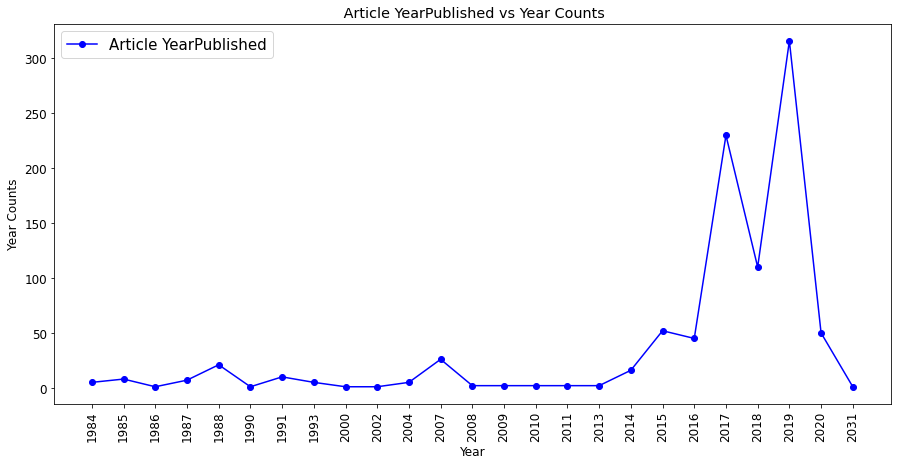

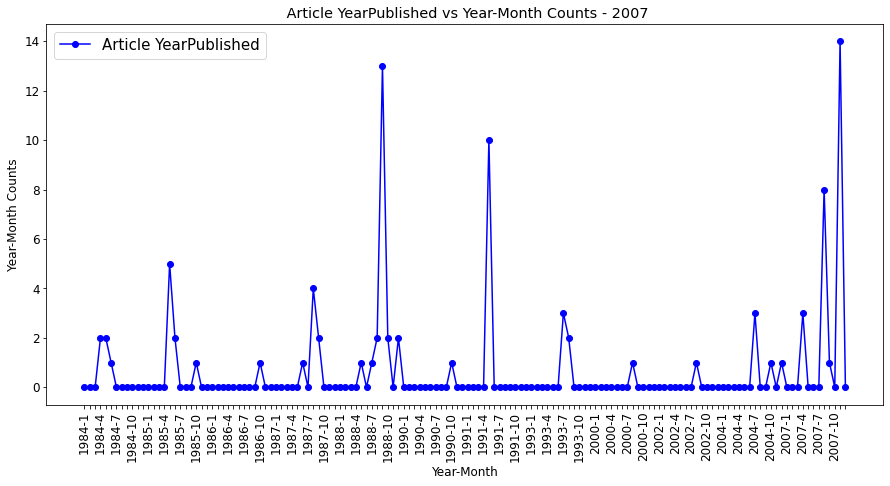

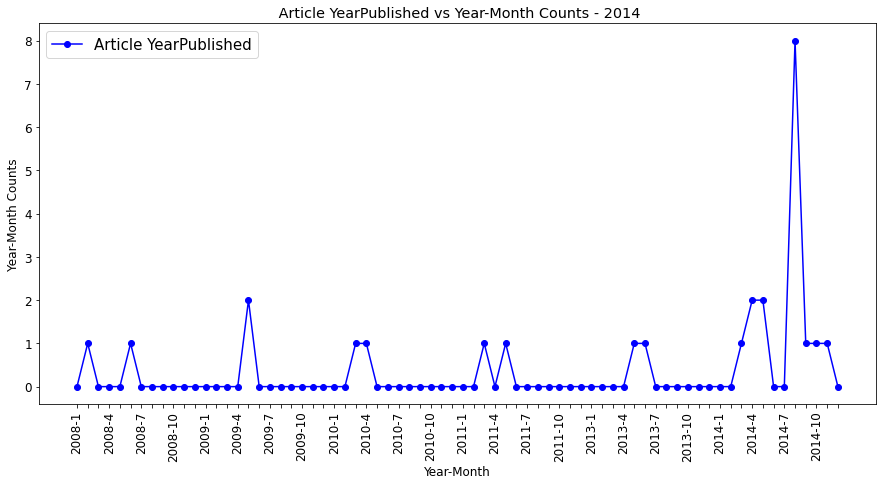

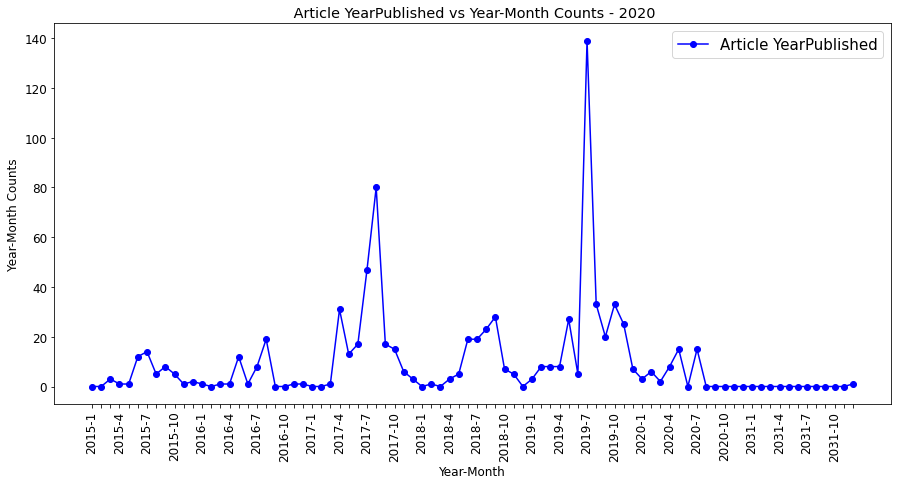

In [157]:
plot_year_yearmonth(df_data, '', 'all.json')

('No Date Present', 'None') None


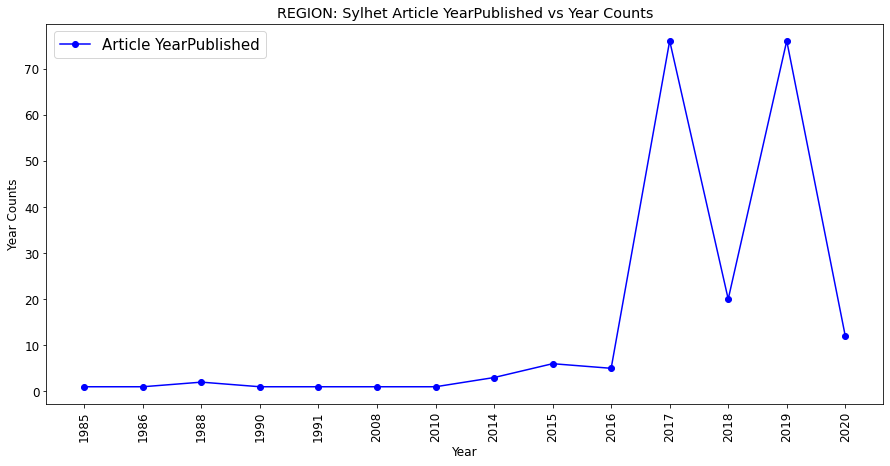

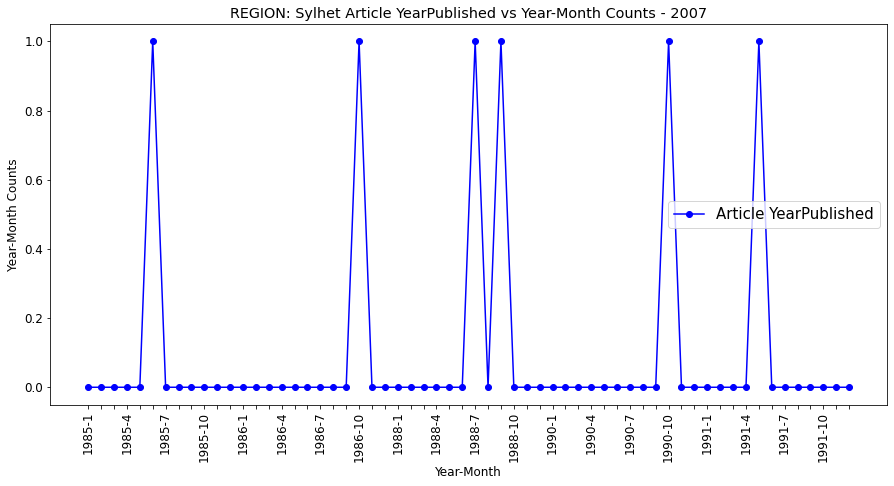

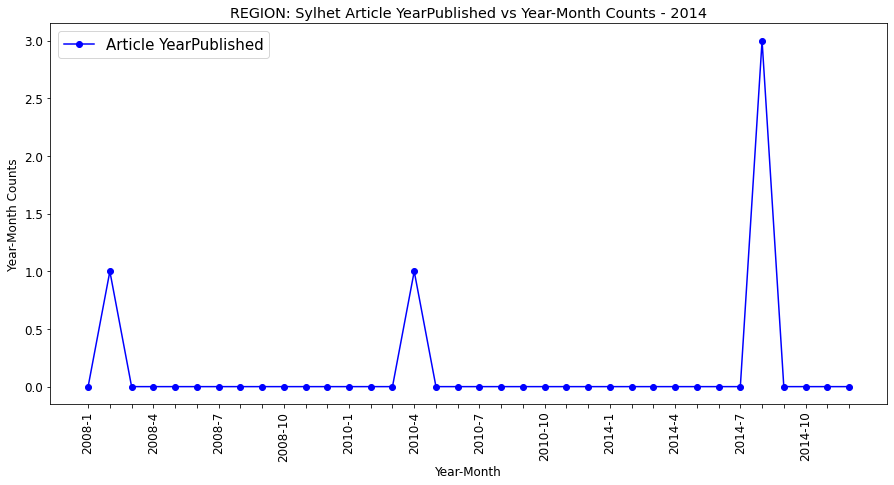

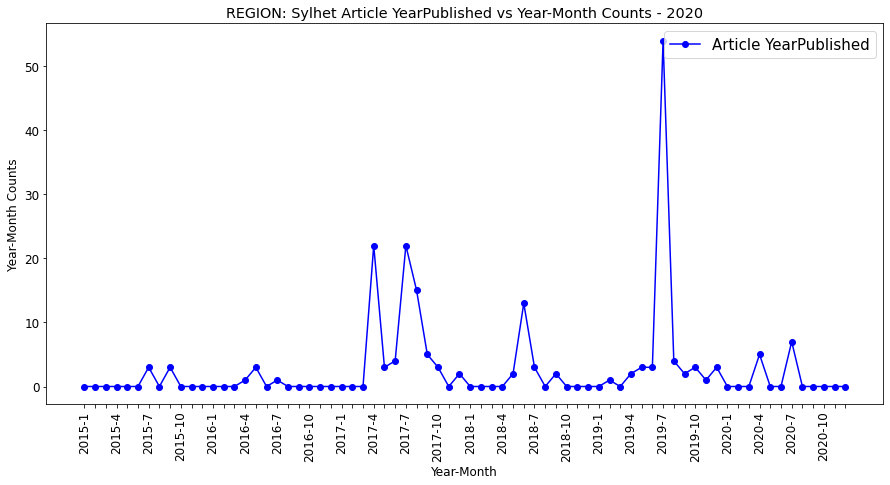

In [159]:
plot_year_yearmonth(get_division_articles(df_data,'sylhet'), 'REGION: Sylhet', 'timeseries_data/sylhet.json')

('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None


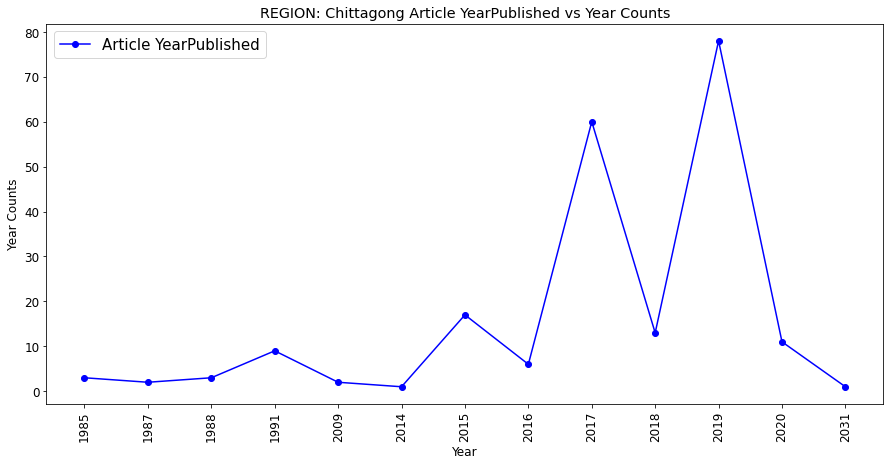

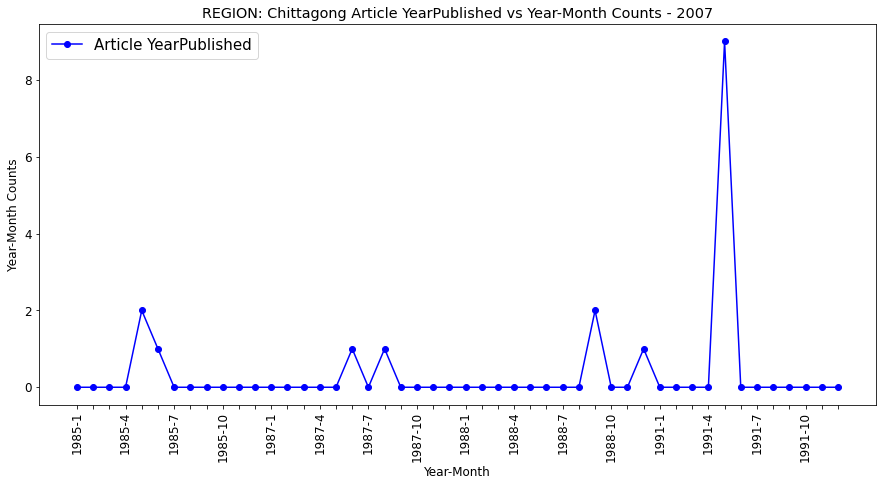

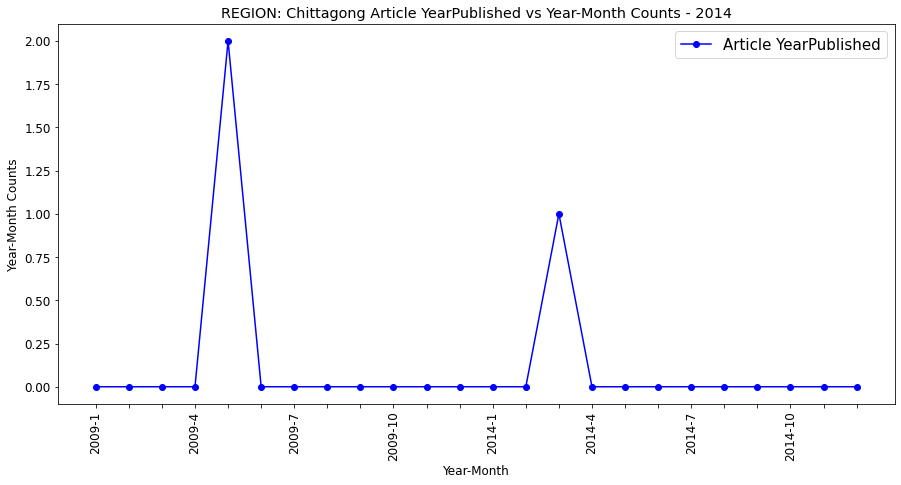

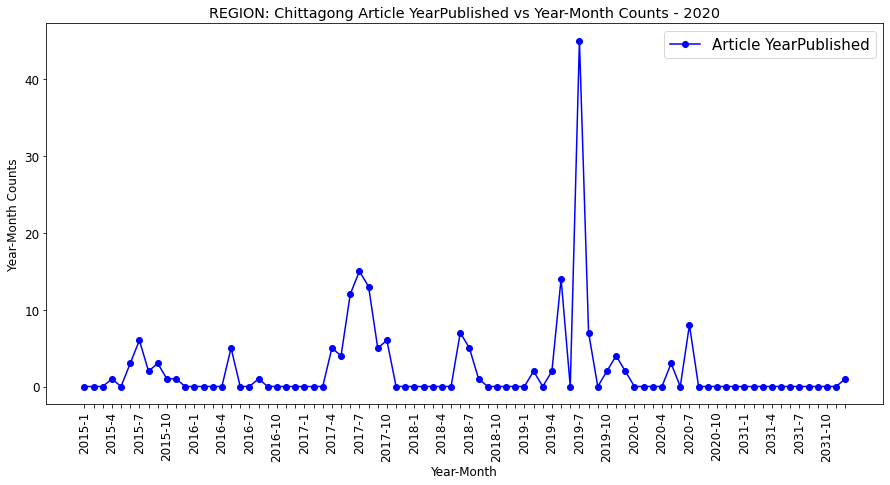

In [160]:
plot_year_yearmonth(get_division_articles(df_data,'chittagong'), 'REGION: Chittagong', 'timeseries_data/chittagong.json')


('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None


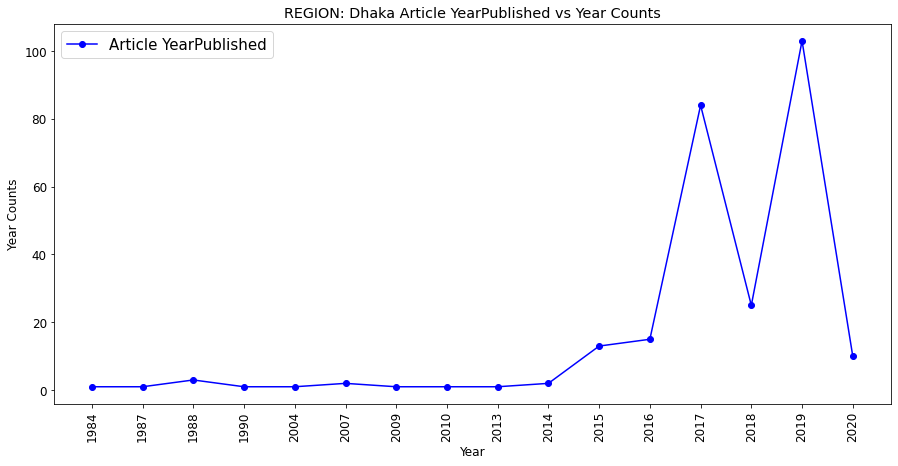

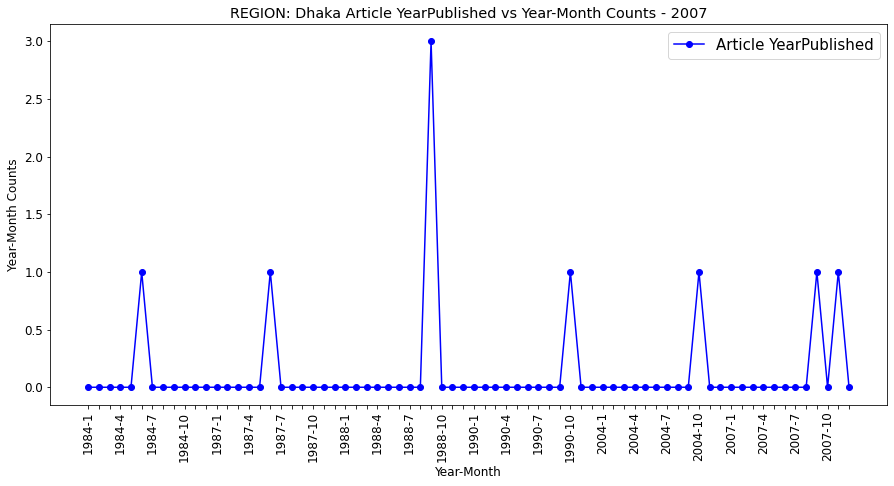

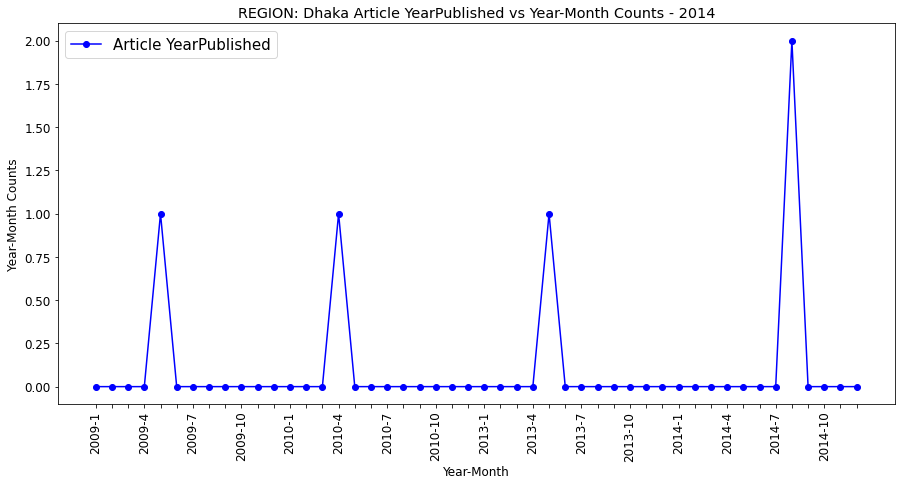

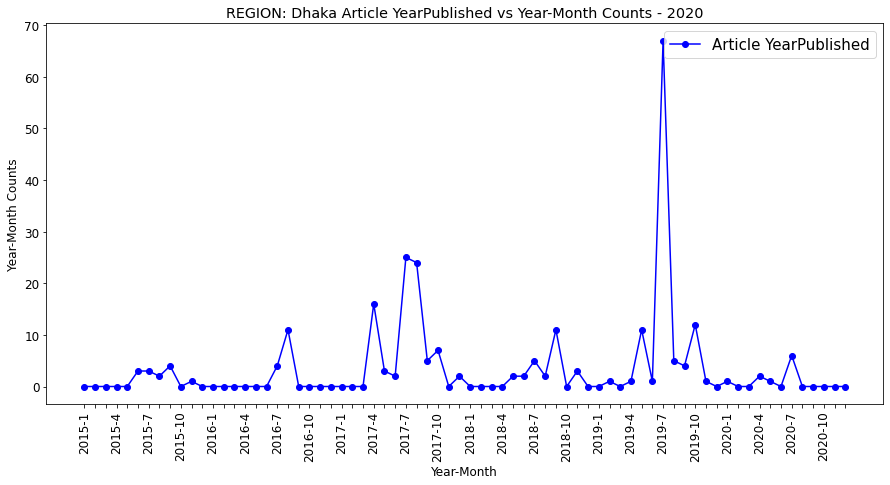

In [161]:
plot_year_yearmonth(get_division_articles(df_data,'dhaka'), 'REGION: Dhaka', 'timeseries_data/dhaka.json')


('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None


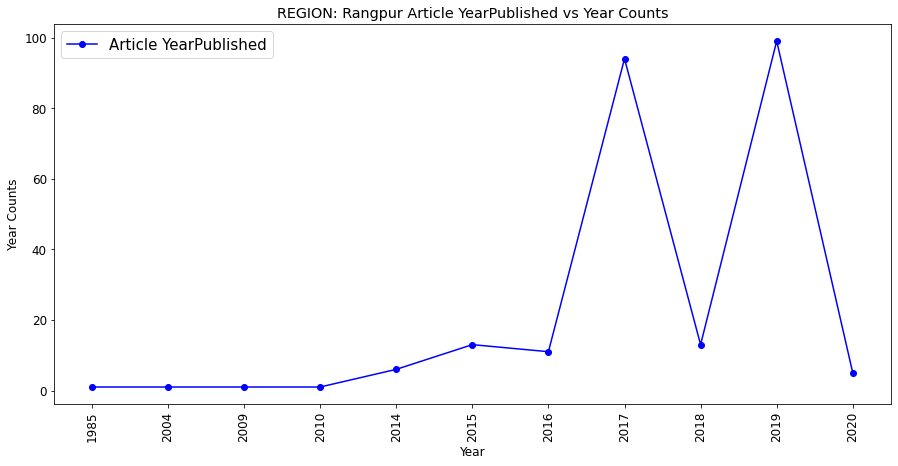

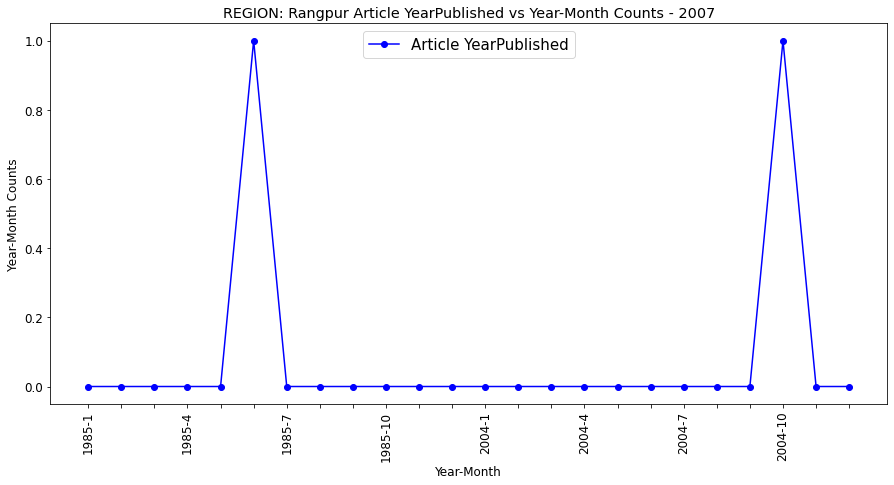

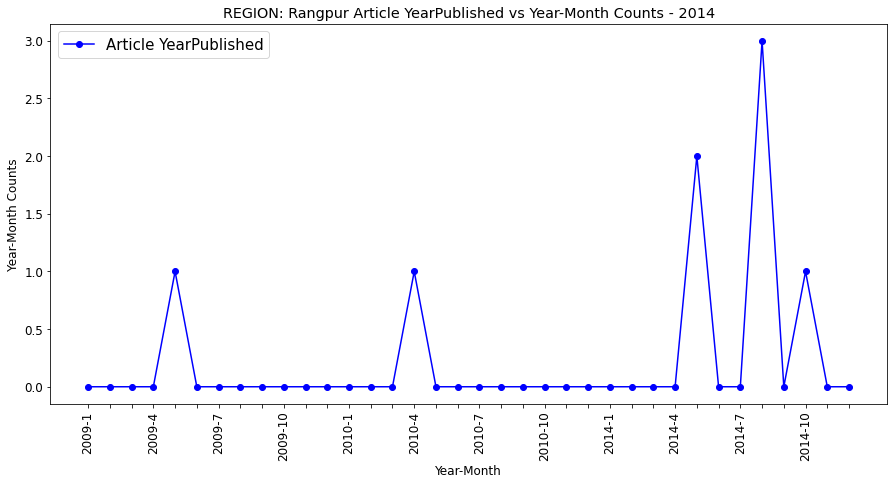

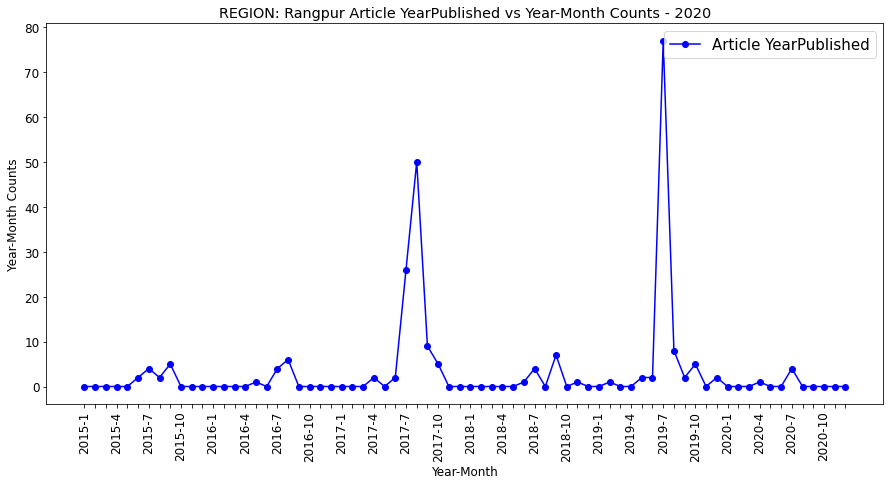

In [162]:
plot_year_yearmonth(get_division_articles(df_data,'rangpur'), 'REGION: Rangpur', 'timeseries_data/rangpur.json')


('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None


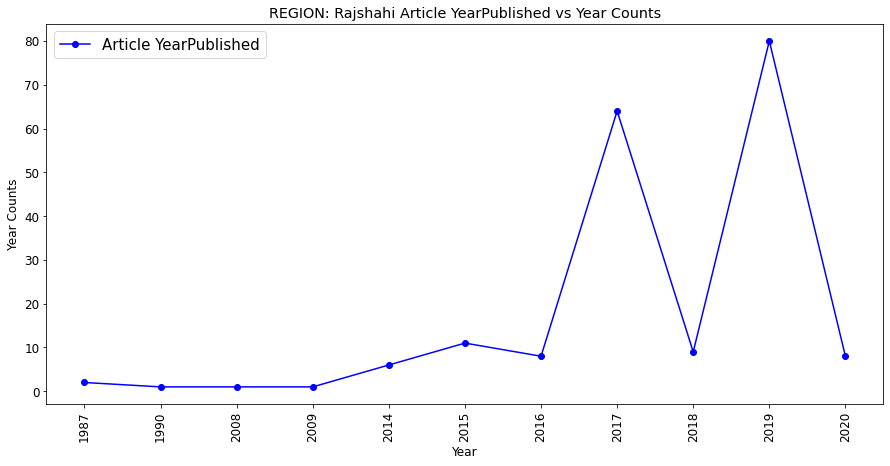

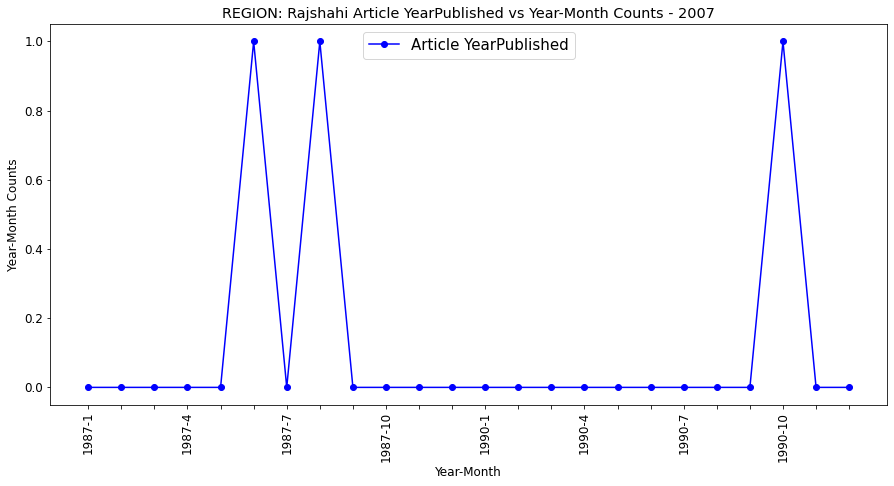

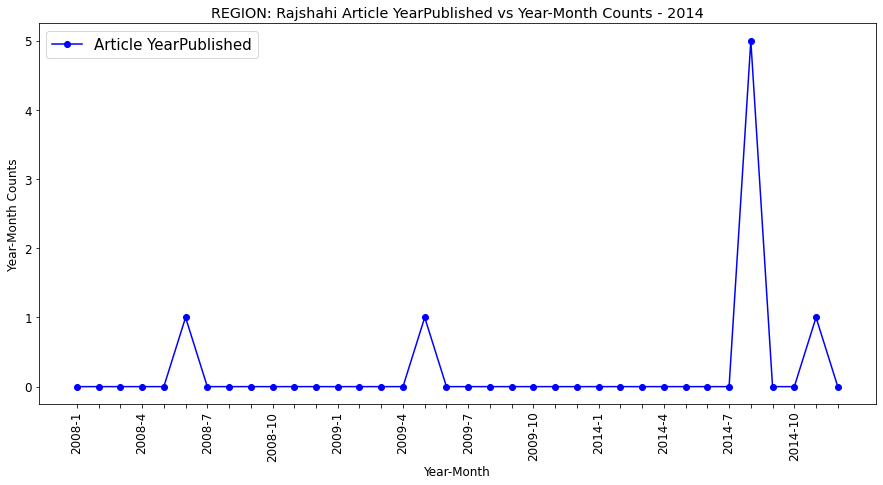

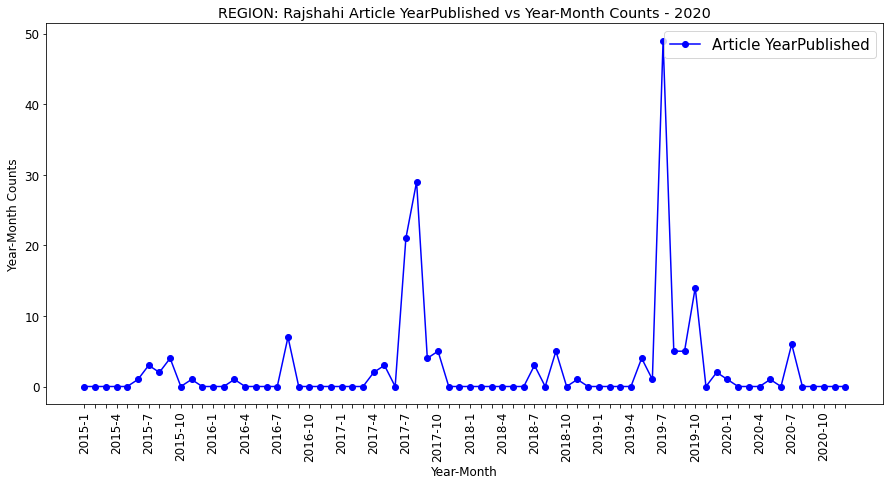

In [163]:
plot_year_yearmonth(get_division_articles(df_data,'rajshahi'), 'REGION: Rajshahi', 'timeseries_data/rajshahi.json')


('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None


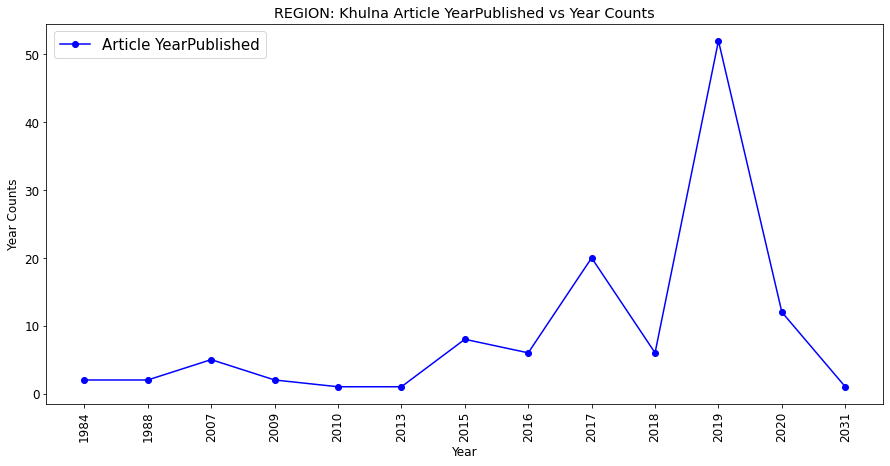

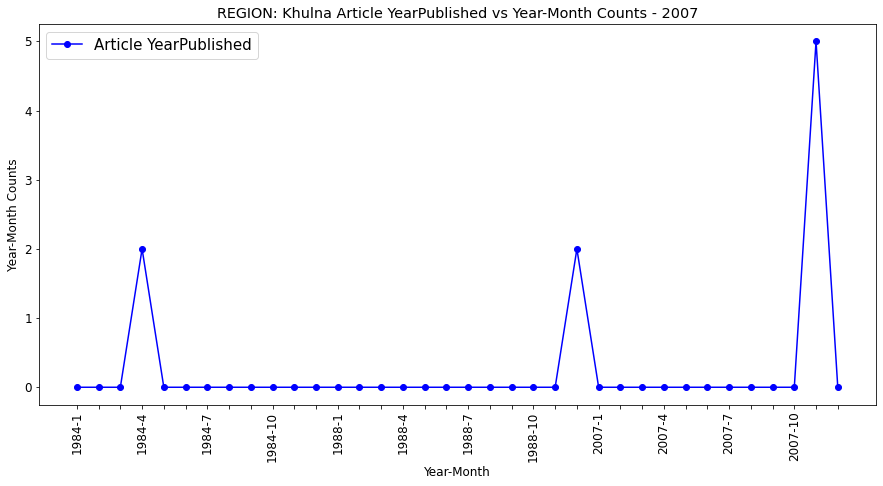

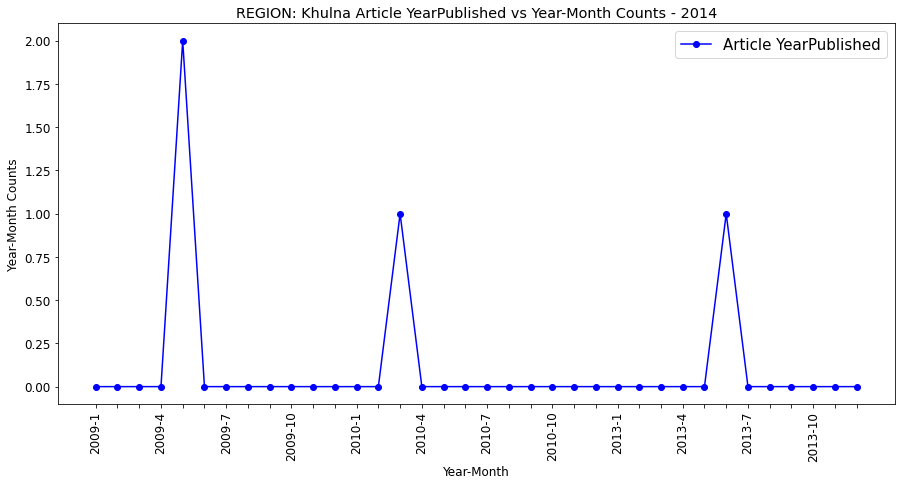

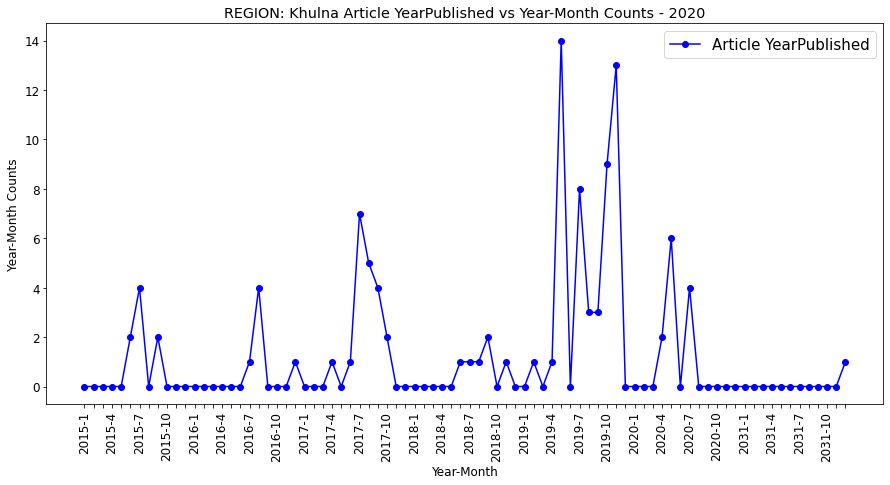

In [164]:
plot_year_yearmonth(get_division_articles(df_data,'khulna'), 'REGION: Khulna', 'timeseries_data/khulna.json')


('No Date Present', 'None') None
('No Date Present', 'None') None


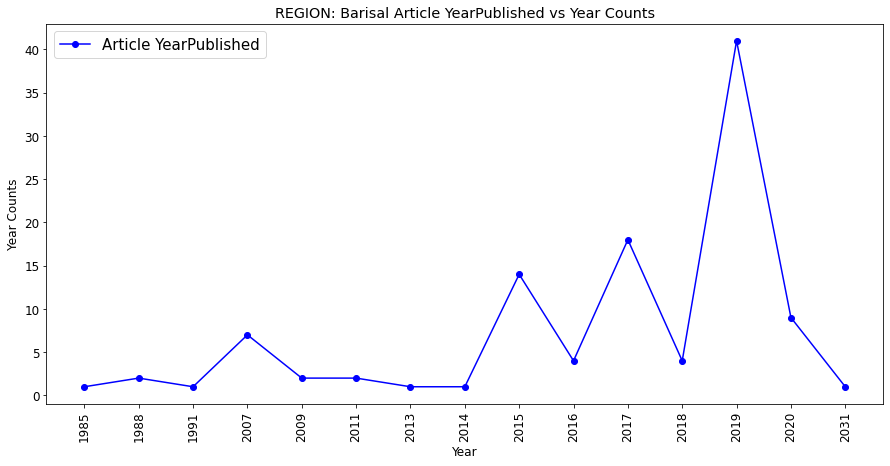

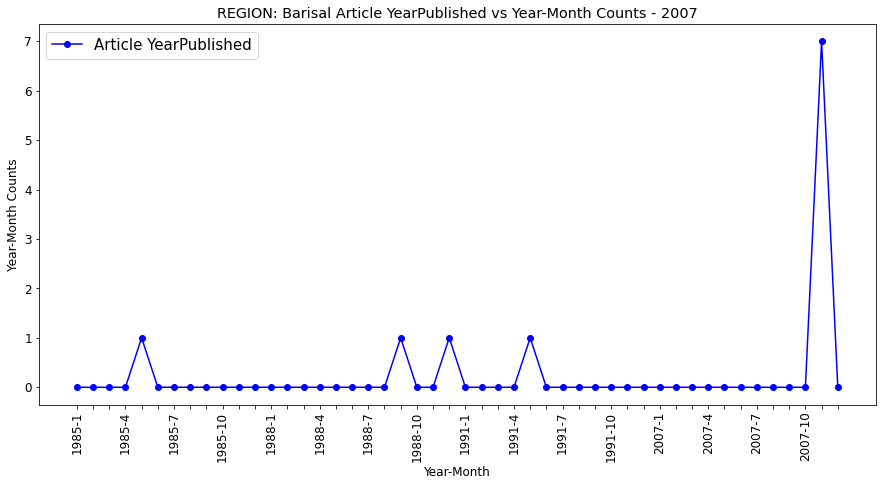

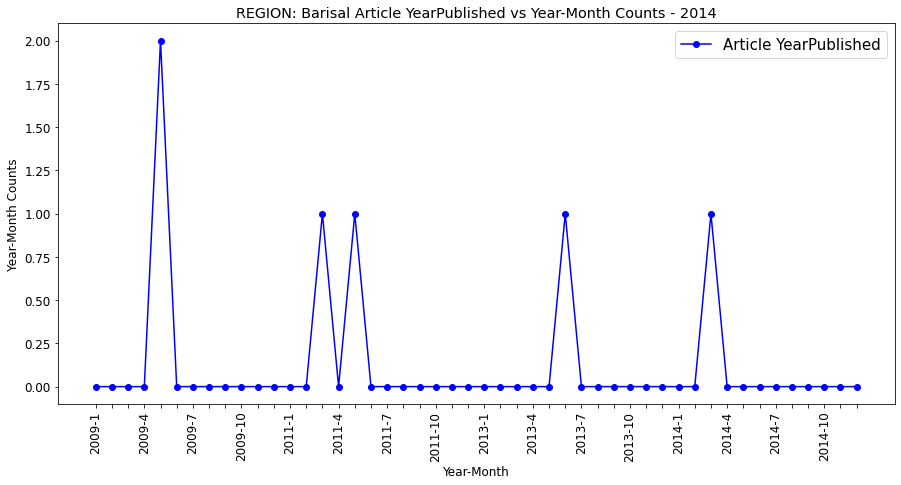

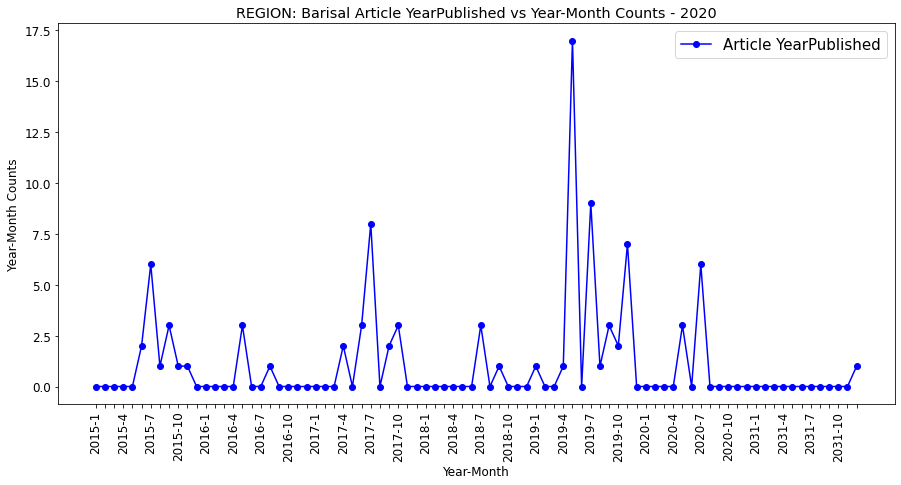

In [165]:
plot_year_yearmonth(get_division_articles(df_data,'barisal'), 'REGION: Barisal','timeseries_data/barisal.json')


In [166]:
# District Missing: Chapainawabganj
# Division Missing: Mymensingh

### Newspaper Types

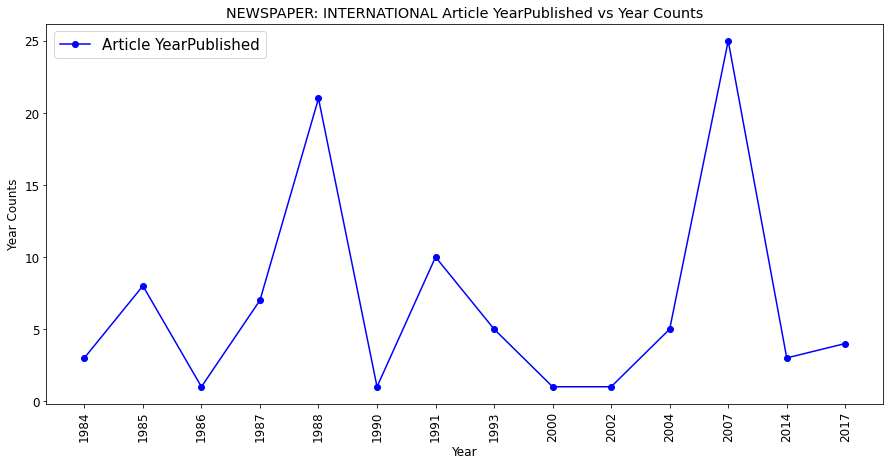

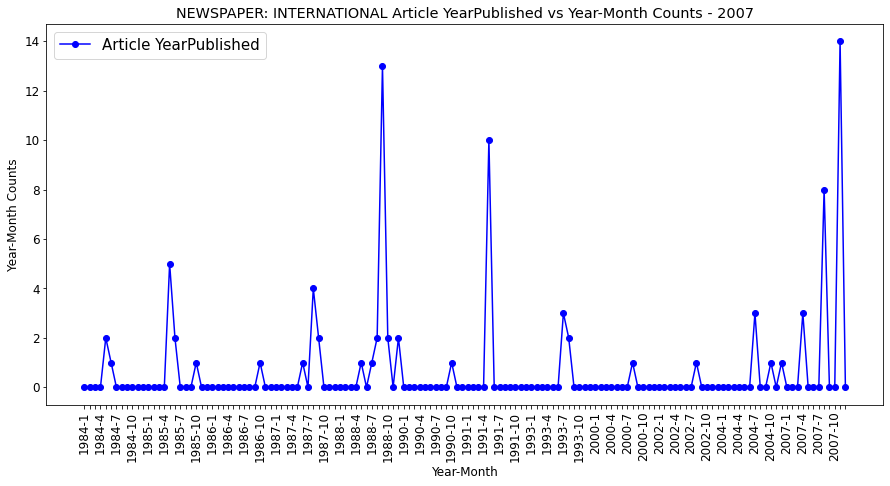

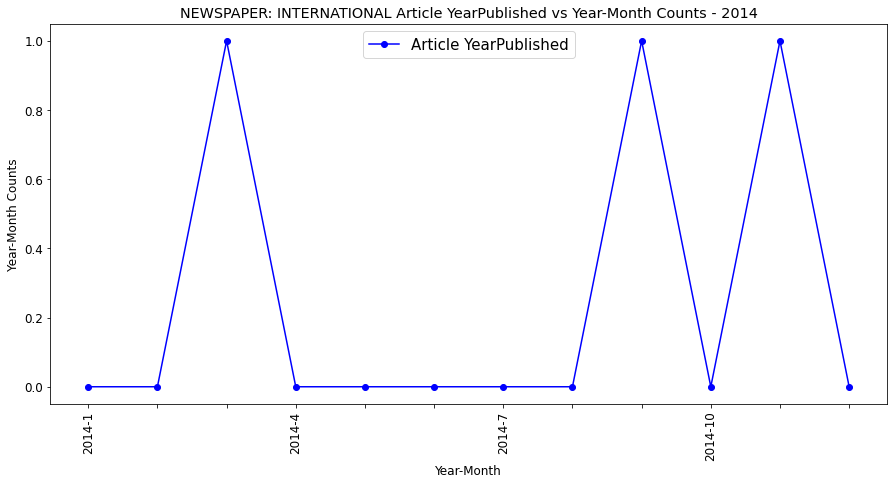

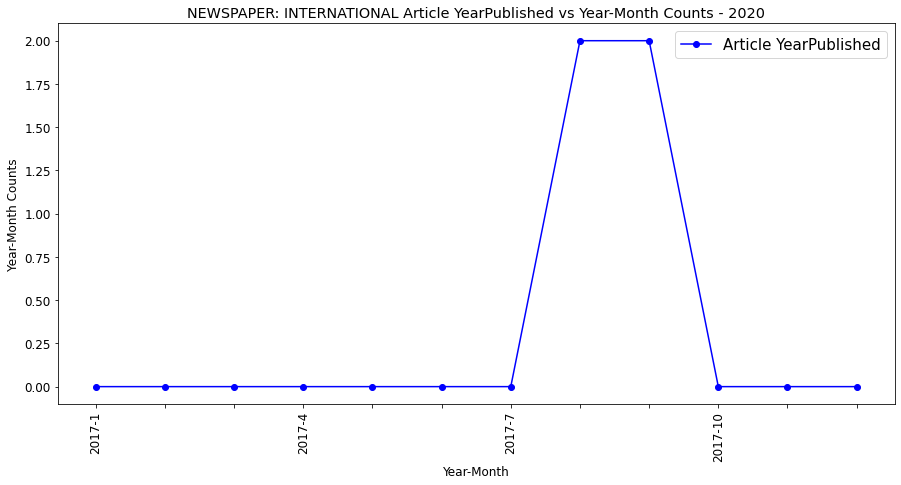

In [167]:
international = ['nytimes']
national = ['thedailystar', 'prothomalo', 'dailySun', 'theIndependent', 'dhakaTribune', 
            'dailyObserver', 'newAge', 'bdnews', 'thedailystar']
plot_year_yearmonth(get_newspaper_articles(df_data, international), 
                    'NEWSPAPER: INTERNATIONAL', 'timeseries_data/international_newspaper.json')


('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None


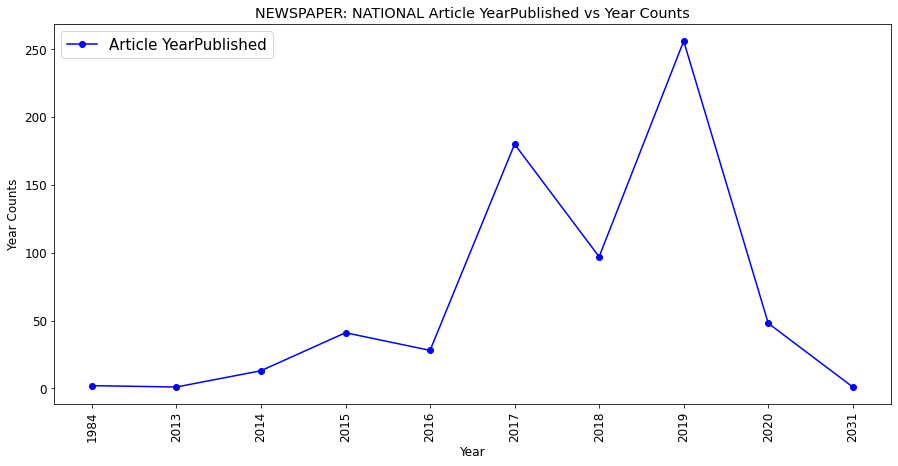

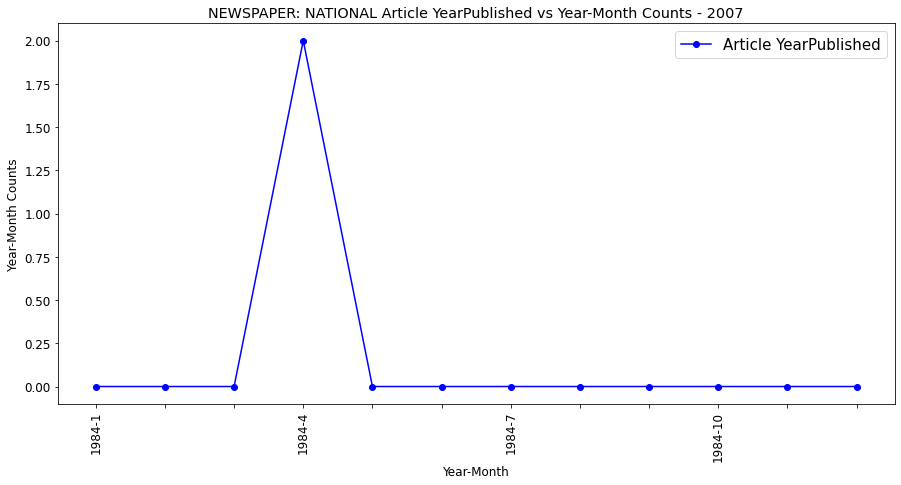

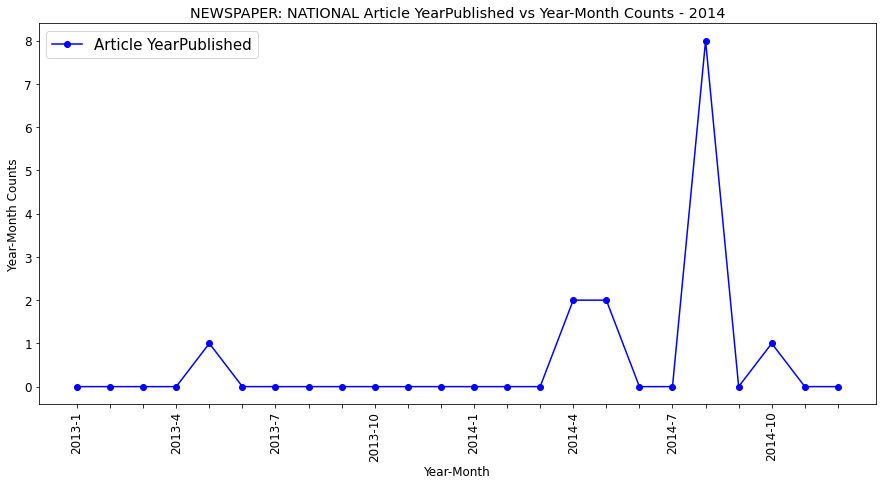

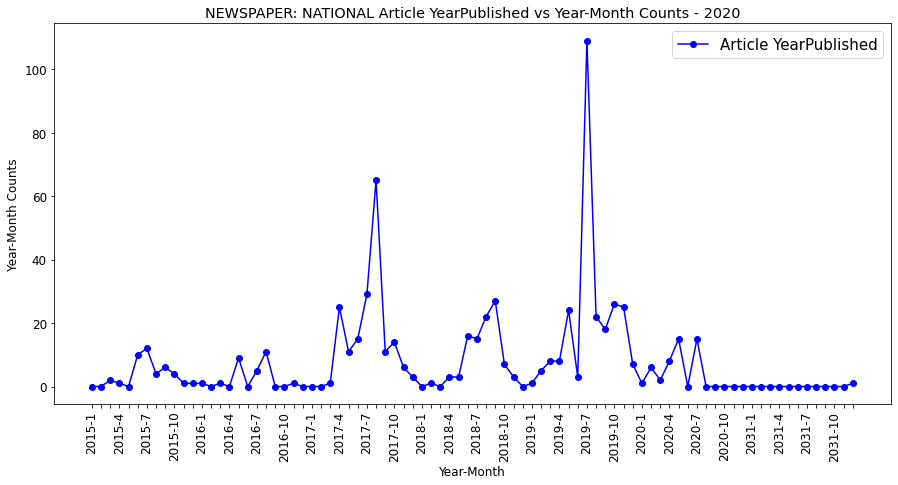

In [168]:
plot_year_yearmonth(get_newspaper_articles(df_data, national), 
                    'NEWSPAPER: NATIONAL', 'timeseries_data/national_newspaper.json')


### Detrending

In [301]:
def get_district_articles_distribution(df_data, top=0):
    div_to_dist, dist_to_div = get_dist_divD()
    districts = list(dist_to_div)
    districts_df, districts_n, dist_top = {}, {}, []
    for d in districts:
        temp_df = get_district_articles(df_data, d)
        dates = parse_all_dates(temp_df['datePublished'])
        dist_top.append((d,len(dates)))
        years, months = [], []
        for d3 in dates:
            if d3:
                years.append(d3['year'])
                months.append(d3['month'])
            else:
                years.append(0)
                months.append(0)
        temp_df['years'], temp_df['months'] = years, months
        temp_df['location'] = [d for _ in range(len(temp_df))]
        districts_df[d] = temp_df[['doc_id', 'filename', 'years', 'months', 'location', 'newspaper']] \
                            .sort_values(by=['years', 'months'])
        yearPublished_count_list, yearPublished_month_count_list = date_counts(dates)
        yearPublished_month_count_list = get_month_range(yearPublished_month_count_list, [2017, 2020])
        districts_n[d] = {
            'yearPublished': yearPublished_count_list,
            'year_monthPublished': yearPublished_month_count_list
        }
    if top:
        dist_top.sort(key=lambda x:x[1], reverse=True)
        new_districts_df, new_districts_n = {}, {}
        for dist, distn in dist_top[:top]:
            new_districts_df[dist] = districts_df[dist]
            new_districts_n[dist] = districts_n[dist]
        return new_districts_df, new_districts_n
    return districts_df, districts_n
districts_df, districts_n = get_district_articles_distribution(df_data, top=10)

('No Date Present', 'None') None
('No Date Present', 'None') None


/Users/tejitpabari/Desktop/BangladeshFloodResearch/bangladesh_flood_venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/tejitpabari/Desktop/BangladeshFloodResearch/bangladesh_flood_venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date 

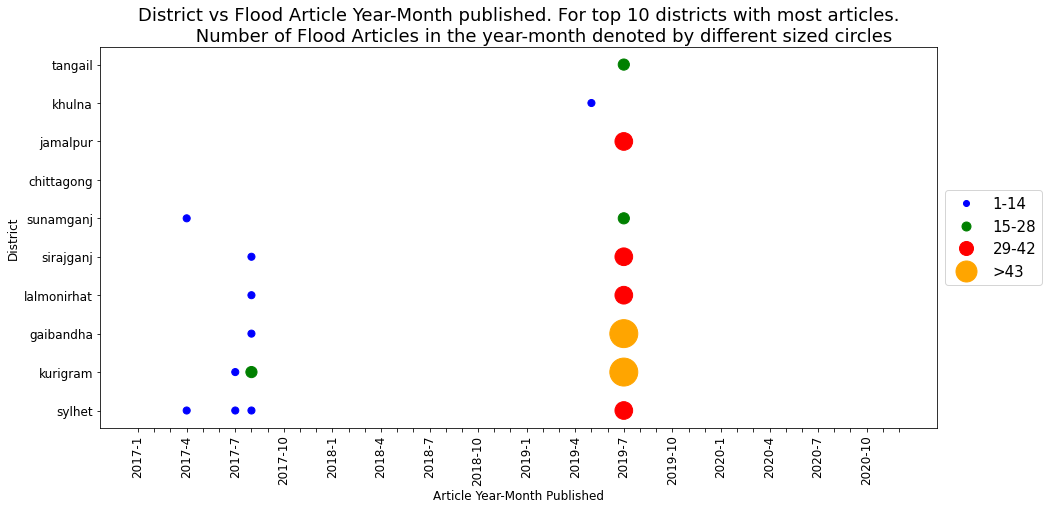

In [327]:
def get_s_val(currVal, minVal, maxVal, div=4):
    diff = (maxVal-minVal)//div
    return 20*2.5**(currVal//diff) if currVal//diff else 0

def get_colors(currVal, minVal, maxVal, div=4):
    colors = ['#FFFF00','#0000FF','#008000','#FF0000','#FFA500']
    diff = (maxVal-minVal)//div
    return colors[currVal//diff]

def get_labels(currVal, minVal, maxVal, div=4):
    diff = (maxVal-minVal)//div
    if currVal==0: return ''
    for i in range(div):
        if i==div-1: return '>{}'.format((diff*i)+1)
        if (diff*i)+1 <= currVal <= diff*(i+1):
            return '{}-{}'.format((diff*i)+1,diff*(i+1))
    return ''
    
def plot_district_articles_distribution(districts_n, title=None, xlabel=None, ylabel=None, 
                                        xticks_rotate=True, skip=True):
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    div = 4
    fig, ax = plt.subplots(figsize=(15,7))
    xvals = [i[0] for i in districts_n['sylhet']['year_monthPublished']]
    yvals_name = list(districts_n)
    yvals = [[districts_n[dname]['year_monthPublished'][i][1] for dname in yvals_name] for i,ym in enumerate(xvals)]
    maxVal, minVal = -float('inf'), float('inf')
    for y in yvals:
        for count in y:
            maxVal, minVal = max(maxVal, count), min(minVal, count)
    for i in range(len(xvals)):
        ax.scatter([xvals[i]]*len(yvals[i]), range(len(yvals[i])), 
                   s=[get_s_val(i,minVal,maxVal) for i in yvals[i]], 
                   c=[get_colors(i,minVal,maxVal) for i in yvals[i]])
    legend_elements = [Line2D([0], [0], linewidth=0, marker='o', 
                              color=get_colors(((maxVal-minVal)//div)*i, minVal, maxVal), 
                              label=get_labels(((maxVal-minVal)//div)*i, minVal, maxVal),
                              markerfacecolor=get_colors(((maxVal-minVal)//div)*i, minVal, maxVal), 
                              markersize=i**2+5)
                       for i in range(div+1) if i!=0
                   ]
    
    plt.legend(handles=legend_elements, fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))
    if not title: title = 'District vs Flood Article Year-Month published. For top 10 districts with most articles.\n \
        Number of Flood Articles in the year-month denoted by different sized circles'
    if not xlabel: xlabel = 'Article Year-Month Published'
    if not ylabel: ylabel = 'District'
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yticks(range(len(yvals_name)), labels=yvals_name)
    if xticks_rotate: plt.xticks(rotation='vertical')
    if skip:
        ax = plt.gca()
        temp = ax.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::3]))
        for label in temp:
            label.set_visible(False)
    plt.show()
plot_district_articles_distribution(districts_n)